# Tarea 2 - Autoencoder en PyTorch

En esta tarea vamos a construir una red neuronal Autoencoder usando PyTorch. Un autoencoder es una red que aprende a comprimir y luego reconstruir los datos de entrada.

In [1]:
# Importar las librerías necesarias
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Verificar si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cpu


## Dataset MNIST

MNIST es el dataset más simple y popular para empezar con redes neuronales:

- **70,000 imágenes** de dígitos escritos a mano (0-9)
- **28x28 píxeles** en escala de grises (1 canal)
- **60,000 imágenes de entrenamiento** y **10,000 de prueba**
- Cada imagen es un dígito del 0 al 9

Es perfecto para nuestro autoencoder porque:
- Las imágenes son simples (solo números)
- Solo 1 canal (blanco y negro) vs 3 canales RGB
- Menor resolución (28x28 vs 32x32)
- El modelo entrenamás rápido y da mejores resultados

Vamos a cargar algunas imágenes para ver cómo se ven.

Descargando MNIST (es muy rápido)...
Dataset cargado correctamente!
Forma de las imágenes: torch.Size([8, 1, 28, 28])
Total de imágenes en el dataset de prueba: 10000


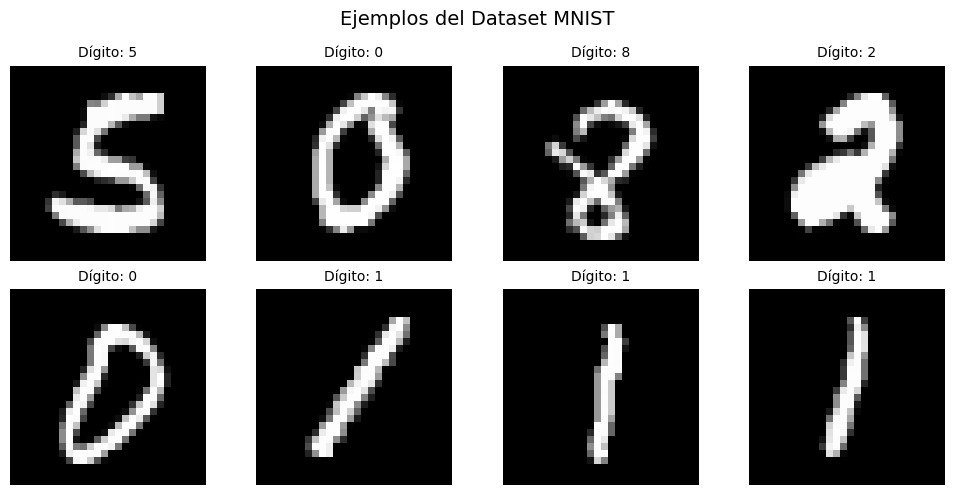

In [2]:
# Cargar y visualizar imágenes de MNIST
def load_and_show_mnist():
    """
    Carga MNIST y muestra algunas imágenes de ejemplo
    """
    # Transformaciones: convertir a tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Cargar dataset de prueba de MNIST
    print("Descargando MNIST (es muy rápido)...")
    testset = torchvision.datasets.MNIST(root='./data', train=False, 
                                        download=True, transform=transform)
    
    # Crear dataloader
    testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=True)
    
    # Obtener un batch de imágenes
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    
    print(f"Dataset cargado correctamente!")
    print(f"Forma de las imágenes: {images.shape}")
    print(f"Total de imágenes en el dataset de prueba: {len(testset)}")
    
    # Mostrar las imágenes de ejemplo
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    fig.suptitle('Ejemplos del Dataset MNIST', fontsize=14)
    
    for i in range(8):
        row = i // 4
        col = i % 4
        
        # MNIST ya está en escala de grises, solo necesitamos squeeze
        img = images[i].squeeze()  # quitar la dimensión del canal
        
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'Dígito: {labels[i]}', fontsize=10)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return testloader

# Cargar dataset y mostrar ejemplos
testloader = load_and_show_mnist()

## Autoencoder

In [3]:
# Definir la arquitectura del Autoencoder para MNIST (28x28, 1 canal)
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # ENCODER - Esta parte comprime la imagen original
        # Conv2d: aplica filtros convolucionales para detectar características
        # ReLU: función de activación que introduce no linealidad
        # MaxPool2d: reduce el tamaño espacial de la imagen
        
        self.encoder = nn.Sequential(
            # Primera capa convolucional: de 1 canal (escala de grises) a 16 filtros
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # mantiene 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # reduce de 28x28 a 14x14
            
            # Segunda capa: de 16 a 8 filtros
            nn.Conv2d(16, 8, kernel_size=3, padding=1),  # mantiene 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # reduce de 14x14 a 7x7
            
            # Tercera capa: de 8 a 4 filtros (representación más comprimida)
            nn.Conv2d(8, 4, kernel_size=3, padding=1),   # mantiene 7x7
            nn.ReLU(),
        )
        
        # DECODER - Esta parte reconstruye la imagen
        # CLAVE: Sin Sigmoid al final para permitir mejor aprendizaje
        
        self.decoder = nn.Sequential(
            # Primera capa del decoder: de 4 a 8 filtros
            nn.ConvTranspose2d(4, 8, kernel_size=2, stride=2),  # aumenta de 7x7 a 14x14
            nn.ReLU(),
            
            # Segunda capa: de 8 a 16 filtros
            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2), # aumenta de 14x14 a 28x28
            nn.ReLU(),
            
            # Tercera capa: de 16 a 1 canal (escala de grises original)
            # SIN Sigmoid - esta era la causa principal del problema!
            nn.Conv2d(16, 1, kernel_size=3, padding=1),         # mantiene 28x28, regresa a 1 canal
            # La activación se aplicará solo para visualización, no en el entrenamiento
        )
    
    def forward(self, x):
        # Pasar la imagen por el encoder (compresión)
        encoded = self.encoder(x)
        # Pasar la representación comprimida por el decoder (reconstrucción)
        decoded = self.decoder(encoded)
        return decoded

# Crear una instancia del modelo
model = Autoencoder().to(device)
print("Modelo creado correctamente")
print(f"Número de parámetros: {sum(p.numel() for p in model.parameters())}")

Modelo creado correctamente
Número de parámetros: 2421


In [4]:
# Mostrar la arquitectura completa del modelo
print("=== ARQUITECTURA DEL AUTOENCODER ===")
print("\nENCODER (Compresión):")
for i, layer in enumerate(model.encoder):
    print(f"  {i+1}. {layer}")

print("\nDECODER (Reconstrucción):")
for i, layer in enumerate(model.decoder):
    print(f"  {i+1}. {layer}")

print("\n=== RESUMEN ===")
print("- El encoder reduce una imagen 28x28x1 a una representación 7x7x4")
print("- El decoder reconstruye de 7x7x4 de vuelta a 28x28x1")
print("- La representación comprimida es 16 veces más pequeña que la original")
print("- Diseñado para dígitos de MNIST (más simple que CIFAR-10)")

=== ARQUITECTURA DEL AUTOENCODER ===

ENCODER (Compresión):
  1. Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  2. ReLU()
  3. MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  4. Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  5. ReLU()
  6. MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  7. Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  8. ReLU()

DECODER (Reconstrucción):
  1. ConvTranspose2d(4, 8, kernel_size=(2, 2), stride=(2, 2))
  2. ReLU()
  3. ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  4. ReLU()
  5. Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

=== RESUMEN ===
- El encoder reduce una imagen 28x28x1 a una representación 7x7x4
- El decoder reconstruye de 7x7x4 de vuelta a 28x28x1
- La representación comprimida es 16 veces más pequeña que la original
- Diseñado para dígitos de MNIST (más simple que CIFAR-10)


In [5]:
# Configurar el entrenamiento del autoencoder
# Función de pérdida: MSE (Mean Squared Error) - mide qué tan diferentes son las imágenes
criterion = nn.MSELoss()

# Optimizador: Adam - algoritmo que ajusta los pesos del modelo para minimizar la pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Configuración para Gradient Accumulation
ACCUMULATION_STEPS = 4  # Acumular gradientes durante 4 steps antes de actualizar
EFFECTIVE_BATCH_SIZE = 64 * ACCUMULATION_STEPS  # Batch efectivo = 64 * 4 = 256

print("=== CONFIGURACIÓN DEL ENTRENAMIENTO CON GRADIENT ACCUMULATION ===")
print(f"Función de pérdida: {criterion}")
print(f"Optimizador: {optimizer.__class__.__name__}")
print(f"Tasa de aprendizaje: 0.001")
print(f"Accumulation steps: {ACCUMULATION_STEPS}")
print(f"Batch size real: 64")
print(f"Batch size efectivo: {EFFECTIVE_BATCH_SIZE}")
print("\nGradient Accumulation permite simular batches grandes con memoria limitada")

=== CONFIGURACIÓN DEL ENTRENAMIENTO CON GRADIENT ACCUMULATION ===
Función de pérdida: MSELoss()
Optimizador: Adam
Tasa de aprendizaje: 0.001
Accumulation steps: 4
Batch size real: 64
Batch size efectivo: 256

Gradient Accumulation permite simular batches grandes con memoria limitada


## Gradient Accumulation

es una técnica que permite simular batches más grandes cuando hay limitaciones de memoria. 

### Como funciona:

1. **Batch pequeño**: Procesar batch de tamaño pequeño (ej: 64)
2. **Acumular gradientes**: Hacer backward() pero NO actualizar pesos
3. **Repetir**: Procesar varios batches pequeños acumulando gradientes
4. **Actualizar**: Después de N steps, actualizar pesos una sola vez

En nuestro caso: `64 (batch real) × 4 (accumulation steps) = 256 (batch efectivo)`

In [6]:
# Función para entrenar el autoencoder con MNIST usando Gradient Accumulation
def train_autoencoder_with_gradient_accumulation(num_epochs=2):
    """
    Entrena el autoencoder con MNIST implementando Gradient Accumulation.
    """
    # Preparar los datos de entrenamiento
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                         download=True, transform=transform)
    # Batch size más pequeño ya que vamos a acumular
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    
    print(f"=== ENTRENAMIENTO CON GRADIENT ACCUMULATION ({num_epochs} épocas) ===")
    print(f"Total de batches por época: {len(trainloader)}")
    print(f"Steps de acumulación: {ACCUMULATION_STEPS}")
    print(f"Actualizaciones efectivas por época: {len(trainloader) // ACCUMULATION_STEPS}")
    
    # Poner el modelo en modo entrenamiento
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        accumulated_loss = 0.0
        num_updates = 0
        
        # Limpiar gradientes al inicio de cada época
        optimizer.zero_grad()
        
        for i, (images, _) in enumerate(trainloader):
            # No necesitamos las etiquetas, solo las imágenes
            images = images.to(device)
            
            # Forward pass - pasar imágenes por el autoencoder
            reconstructed = model(images)
            
            # Calcular pérdida (diferencia entre original y reconstruida)
            loss = criterion(reconstructed, images)
            
            # GRADIENT ACCUMULATION: Dividir la pérdida por el número de steps
            # Esto normaliza el gradiente para el batch efectivo
            loss = loss / ACCUMULATION_STEPS
            
            # Backward pass - ACUMULAR gradientes (no actualizar pesos aún)
            loss.backward()
            
            # Acumular pérdida para estadísticas
            accumulated_loss += loss.item()
            running_loss += loss.item()
            
            # Actualizar pesos solo cada ACCUMULATION_STEPS
            if (i + 1) % ACCUMULATION_STEPS == 0:
                # Actualizar pesos con gradientes acumulados
                optimizer.step()
                
                # Limpiar gradientes para la siguiente acumulación
                optimizer.zero_grad()
                
                num_updates += 1
                
                # Mostrar progreso cada 50 actualizaciones efectivas
                if num_updates % 50 == 0:
                    avg_accumulated_loss = accumulated_loss * ACCUMULATION_STEPS  # Revertir normalización
                    print(f'Época [{epoch+1}/{num_epochs}], Update [{num_updates}], '
                          f'Batch real [{i+1}/{len(trainloader)}], '
                          f'Pérdida acumulada: {avg_accumulated_loss:.4f}')
                
                # Resetear pérdida acumulada
                accumulated_loss = 0.0
        
        # Actualizar pesos restantes si quedaron gradientes sin procesar
        if (len(trainloader)) % ACCUMULATION_STEPS != 0:
            optimizer.step()
            optimizer.zero_grad()
            num_updates += 1
        
        # Mostrar pérdida promedio por época
        avg_loss = running_loss * ACCUMULATION_STEPS / len(trainloader)  # Revertir normalización
        print(f'=== Época {epoch+1} completada ===')
        print(f'    Pérdida promedio: {avg_loss:.4f}')
        print(f'    Actualizaciones realizadas: {num_updates}')
        print(f'    Batch efectivo simulado: {EFFECTIVE_BATCH_SIZE}')
    
    print("\nEntrenamiento con Gradient Accumulation completado")
    
    # Poner el modelo en modo evaluación
    model.eval()

# Entrenar el modelo con Gradient Accumulation
train_autoencoder_with_gradient_accumulation(num_epochs=2)

=== ENTRENAMIENTO CON GRADIENT ACCUMULATION (2 épocas) ===
Total de batches por época: 938
Steps de acumulación: 4
Actualizaciones efectivas por época: 234
Época [1/2], Update [50], Batch real [200/938], Pérdida acumulada: 0.2687
Época [1/2], Update [50], Batch real [200/938], Pérdida acumulada: 0.2687
Época [1/2], Update [100], Batch real [400/938], Pérdida acumulada: 0.1440
Época [1/2], Update [100], Batch real [400/938], Pérdida acumulada: 0.1440
Época [1/2], Update [150], Batch real [600/938], Pérdida acumulada: 0.1145
Época [1/2], Update [150], Batch real [600/938], Pérdida acumulada: 0.1145
Época [1/2], Update [200], Batch real [800/938], Pérdida acumulada: 0.0953
Época [1/2], Update [200], Batch real [800/938], Pérdida acumulada: 0.0953
=== Época 1 completada ===
    Pérdida promedio: 0.0457
    Actualizaciones realizadas: 235
    Batch efectivo simulado: 256
=== Época 1 completada ===
    Pérdida promedio: 0.0457
    Actualizaciones realizadas: 235
    Batch efectivo simulado: 

In [7]:
# Probar el modelo entrenado con nuevas imágenes
def test_trained_model():
    """
    Prueba el autoencoder después del entrenamiento con imágenes frescas
    """
    print("=== PROBANDO MODELO ENTRENADO ===")
    
    # Asegurar que el modelo está en modo evaluación
    model.eval()
    
    # Obtener nuevas imágenes de prueba
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images = images.to(device)
    
    print(f"Probando con dígitos: {labels[:4].tolist()}")
    
    # Reconstruir las imágenes SIN gradientes
    with torch.no_grad():
        reconstructed = model(images)
    
    # Calcular pérdida
    loss = criterion(reconstructed[:4], images[:4])
    print(f"Pérdida de reconstrucción: {loss.item():.4f}")
    
    # Mostrar rangos de valores
    print(f"Rango valores originales: [{images[:4].min():.3f}, {images[:4].max():.3f}]")
    print(f"Rango valores reconstruidos: [{reconstructed[:4].min():.3f}, {reconstructed[:4].max():.3f}]")
    
    return images[:4], reconstructed[:4]

# Ejecutar la prueba después del entrenamiento
print("Probando el modelo entrenado...")
trained_images, trained_reconstructed = test_trained_model()

Probando el modelo entrenado...
=== PROBANDO MODELO ENTRENADO ===
Probando con dígitos: [9, 2, 2, 3]
Pérdida de reconstrucción: 0.0169
Rango valores originales: [0.000, 1.000]
Rango valores reconstruidos: [-0.088, 1.280]


In [8]:
# Función de visualización mejorada para MNIST (sin Sigmoid)
def visualize_reconstruction(original_images, reconstructed_images):
    """
    Visualiza imágenes originales vs reconstruidas con normalización adecuada
    """
    # Convertir tensores a numpy
    original_np = original_images.cpu().detach().numpy()
    reconstructed_np = reconstructed_images.cpu().detach().numpy()
    
    # Crear subplots
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('MNIST: Original vs Reconstruida (Modelo Mejorado)', fontsize=14)
    
    for i in range(4):
        # Imagen original (fila superior)
        img_orig = original_np[i].squeeze()
        axes[0, i].imshow(img_orig, cmap='gray')
        axes[0, i].set_title('Original', fontsize=10)
        axes[0, i].axis('off')
        
        # Imagen reconstruida (fila inferior)
        img_recon = reconstructed_np[i].squeeze()
        
        # CLAVE: Normalizar para visualización ya que no hay Sigmoid
        # Aplicar sigmoid solo para visualización
        img_recon_normalized = torch.sigmoid(torch.tensor(img_recon)).numpy()
        
        axes[1, i].imshow(img_recon_normalized, cmap='gray')
        axes[1, i].set_title('Reconstruida', fontsize=10)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas
    print(f"Estadísticas de reconstrucción:")
    print(f"  Original: min={original_np.min():.3f}, max={original_np.max():.3f}")
    print(f"  Reconstruida (raw): min={reconstructed_np.min():.3f}, max={reconstructed_np.max():.3f}")
    print(f"  Reconstruida (normalizada): min={img_recon_normalized.min():.3f}, max={img_recon_normalized.max():.3f}")

=== COMPARACIÓN DESPUÉS DEL ENTRENAMIENTO ===
Forma de imágenes originales: torch.Size([4, 1, 28, 28])
Forma de imágenes reconstruidas: torch.Size([4, 1, 28, 28])
Rango de valores originales: 0.000 - 1.000
Rango de valores reconstruidas: -0.088 - 1.280


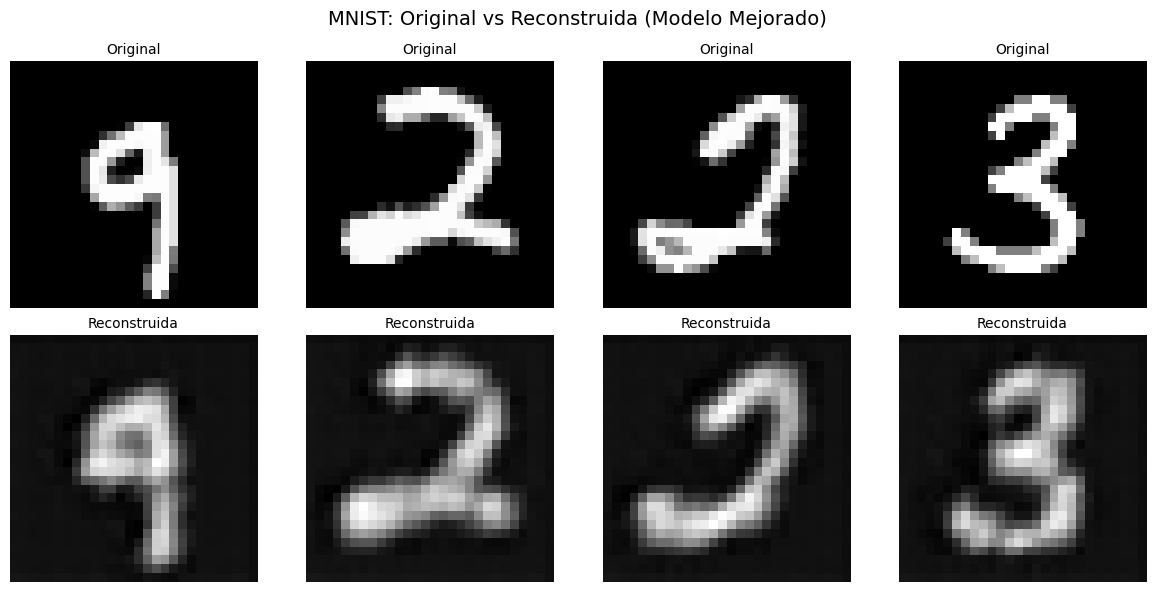

Estadísticas de reconstrucción:
  Original: min=0.000, max=1.000
  Reconstruida (raw): min=-0.088, max=1.280
  Reconstruida (normalizada): min=0.479, max=0.775


In [9]:
# Visualizar las mejores reconstrucciones
print("=== COMPARACIÓN DESPUÉS DEL ENTRENAMIENTO ===")

# Verificar que tenemos los datos
print(f"Forma de imágenes originales: {trained_images.shape}")
print(f"Forma de imágenes reconstruidas: {trained_reconstructed.shape}")
print(f"Rango de valores originales: {trained_images.min():.3f} - {trained_images.max():.3f}")
print(f"Rango de valores reconstruidas: {trained_reconstructed.min():.3f} - {trained_reconstructed.max():.3f}")

# Asegurar que el modelo está en modo evaluación
model.eval()

# Visualizar las reconstrucciones
visualize_reconstruction(trained_images, trained_reconstructed)

## Extra 1: Vision Transformers vs Redes Convolucionales

### Diferencias entre Vision Transformers y Redes Convolucionales

**Redes Convolucionales tradicionales:**
Las CNNs procesan las imágenes aplicando filtros locales que van detectando características desde las más simples hasta las más complejas. Empiezan identificando bordes y texturas en las primeras capas, luego combinan esta información para detectar formas más complejas, y finalmente objetos completos. Este proceso es jerárquico y va construyendo el entendimiento de la imagen paso a paso, manteniendo la información espacial a través de mapas de características.

**Vision Transformers:**
Los ViTs toman un enfoque radicalmente diferente. En lugar de procesar píxel por píxel con filtros locales, dividen la imagen completa en pequeños parches cuadrados que tratan como tokens individuales. Cada parche se convierte en un vector que contiene toda la información de esa región. Luego utilizan mecanismos de atención para que cada parche pueda "ver" y relacionarse con todos los demás parches de la imagen simultáneamente, sin importar qué tan lejos estén unos de otros.

**Ventajas de cada enfoque:**

Los Vision Transformers destacan por su capacidad de capturar relaciones globales entre diferentes partes de la imagen desde el primer momento. Mientras una CNN necesita muchas capas para que información de una esquina de la imagen llegue a la esquina opuesta, un ViT puede conectar directamente cualquier parte de la imagen con cualquier otra. Esto los hace especialmente buenos para entender el contexto global y las relaciones complejas entre objetos distantes.

Las CNNs, por otro lado, tienen una ventaja natural en el procesamiento de patrones locales y son más eficientes computacionalmente para imágenes pequeñas. Su estructura jerárquica refleja naturalmente cómo los humanos percibimos las imágenes, construyendo entendimiento desde características simples hacia conceptos complejos.

In [10]:
# Implementación de Vision Transformer Autoencoder
class PatchEmbedding(nn.Module):
    """
    Convierte la imagen en parches y los convierte en embeddings
    """
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Convolución para crear parches y embeddings al mismo tiempo
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        # x shape: (batch_size, channels, height, width)
        x = self.projection(x)  # (batch_size, embed_dim, n_patches_sqrt, n_patches_sqrt)
        x = x.flatten(2)  # (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (batch_size, n_patches, embed_dim)
        return x

class MultiHeadAttention(nn.Module):
    """
    Mecanismo de atención multi-cabeza para Vision Transformer
    """
    def __init__(self, embed_dim=64, num_heads=4, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attention_dropout = nn.Dropout(dropout)
        self.projection = nn.Linear(embed_dim, embed_dim)
        self.projection_dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, n_patches, embed_dim = x.shape
        
        # Generar Q, K, V
        qkv = self.qkv(x)  # (batch_size, n_patches, embed_dim * 3)
        qkv = qkv.reshape(batch_size, n_patches, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, num_heads, n_patches, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Calcular atención
        scale = self.head_dim ** -0.5
        attention_scores = (q @ k.transpose(-2, -1)) * scale
        attention_probs = attention_scores.softmax(dim=-1)
        attention_probs = self.attention_dropout(attention_probs)
        
        # Aplicar atención a los valores
        out = attention_probs @ v  # (batch_size, num_heads, n_patches, head_dim)
        out = out.transpose(1, 2)  # (batch_size, n_patches, num_heads, head_dim)
        out = out.reshape(batch_size, n_patches, embed_dim)
        
        # Proyección final
        out = self.projection(out)
        out = self.projection_dropout(out)
        
        return out

class TransformerBlock(nn.Module):
    """
    Bloque transformer con atención y MLP
    """
    def __init__(self, embed_dim=64, num_heads=4, mlp_ratio=2, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        # MLP
        mlp_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # Atención con conexión residual
        x = x + self.attention(self.norm1(x))
        # MLP con conexión residual
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformerAutoencoder(nn.Module):
    """
    Autoencoder basado en Vision Transformer
    """
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=64, 
                 num_layers=4, num_heads=4, mlp_ratio=2, dropout=0.1):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        
        # Positional encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.n_patches, embed_dim))
        
        # Encoder transformer blocks
        self.encoder_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])
        
        # Decoder transformer blocks
        self.decoder_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])
        
        # Reconstrucción de imagen
        self.reconstruction_head = nn.Sequential(
            nn.Linear(embed_dim, patch_size * patch_size * in_channels),
            nn.Tanh()  # Para mantener valores en rango apropiado
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Crear parches y embeddings
        x = self.patch_embed(x)  # (batch_size, n_patches, embed_dim)
        
        # Agregar positional encoding
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Encoder
        encoded_features = []
        for block in self.encoder_blocks:
            x = block(x)
            encoded_features.append(x)
        
        # Decoder (usando las características del encoder)
        for block in self.decoder_blocks:
            x = block(x)
        
        # Reconstruir imagen
        x = self.reconstruction_head(x)  # (batch_size, n_patches, patch_size^2)
        
        # Reshape a imagen
        batch_size = x.shape[0]
        patches_per_side = self.img_size // self.patch_size
        
        x = x.reshape(batch_size, patches_per_side, patches_per_side, 
                     self.patch_size, self.patch_size, 1)
        x = x.permute(0, 5, 1, 3, 2, 4)  # (batch_size, channels, h_patches, patch_size, w_patches, patch_size)
        x = x.reshape(batch_size, 1, self.img_size, self.img_size)
        
        return x

# Crear modelo Vision Transformer
vit_model = VisionTransformerAutoencoder(
    img_size=28,
    patch_size=4,
    in_channels=1,
    embed_dim=64,
    num_layers=3,
    num_heads=4,
    dropout=0.1
).to(device)

print("Vision Transformer Autoencoder creado")
print(f"Número de parámetros: {sum(p.numel() for p in vit_model.parameters()):,}")
print(f"Número de parches por imagen: {vit_model.n_patches}")
print(f"Dimensión de embedding: {vit_model.embed_dim}")

Vision Transformer Autoencoder creado
Número de parámetros: 206,096
Número de parches por imagen: 49
Dimensión de embedding: 64


In [11]:
# Configurar entrenamiento para Vision Transformer Autoencoder
vit_criterion = nn.MSELoss()
vit_optimizer = optim.Adam(vit_model.parameters(), lr=0.001, weight_decay=1e-4)

# Configuración de Gradient Accumulation para ViT
VIT_ACCUMULATION_STEPS = 8  # Más steps porque ViT requiere más memoria
VIT_EFFECTIVE_BATCH_SIZE = 32 * VIT_ACCUMULATION_STEPS  # Batch efectivo = 256

print("Configuración de entrenamiento para Vision Transformer:")
print(f"Accumulation steps: {VIT_ACCUMULATION_STEPS}")
print(f"Batch size real: 32")
print(f"Batch size efectivo: {VIT_EFFECTIVE_BATCH_SIZE}")

def train_vit_autoencoder(num_epochs=2):
    """
    Entrena el Vision Transformer Autoencoder con Gradient Accumulation
    """
    # Datos de entrenamiento con batch size más pequeño para ViT
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                         download=True, transform=transform)
    # Batch size más pequeño para ViT debido a mayor uso de memoria
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
    
    print(f"Entrenando Vision Transformer Autoencoder ({num_epochs} épocas)")
    print(f"Total de batches por época: {len(trainloader)}")
    
    vit_model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        accumulated_loss = 0.0
        num_updates = 0
        
        vit_optimizer.zero_grad()
        
        for i, (images, _) in enumerate(trainloader):
            images = images.to(device)
            
            # Forward pass
            reconstructed = vit_model(images)
            
            # Calcular pérdida
            loss = vit_criterion(reconstructed, images)
            loss = loss / VIT_ACCUMULATION_STEPS
            
            # Backward pass - acumular gradientes
            loss.backward()
            
            accumulated_loss += loss.item()
            running_loss += loss.item()
            
            # Actualizar cada VIT_ACCUMULATION_STEPS
            if (i + 1) % VIT_ACCUMULATION_STEPS == 0:
                vit_optimizer.step()
                vit_optimizer.zero_grad()
                num_updates += 1
                
                if num_updates % 20 == 0:
                    avg_loss = accumulated_loss * VIT_ACCUMULATION_STEPS
                    print(f'Época [{epoch+1}/{num_epochs}], Update [{num_updates}], '
                          f'Pérdida: {avg_loss:.4f}')
                
                accumulated_loss = 0.0
        
        # Actualizar gradientes restantes
        if len(trainloader) % VIT_ACCUMULATION_STEPS != 0:
            vit_optimizer.step()
            vit_optimizer.zero_grad()
        
        avg_epoch_loss = running_loss * VIT_ACCUMULATION_STEPS / len(trainloader)
        print(f'Época {epoch+1} completada - Pérdida promedio: {avg_epoch_loss:.4f}')
    
    print("Vision Transformer entrenado con Gradient Accumulation")
    vit_model.eval()

# Entrenar el Vision Transformer (2 épocas porque más demora mucho)
train_vit_autoencoder(num_epochs=2)

Configuración de entrenamiento para Vision Transformer:
Accumulation steps: 8
Batch size real: 32
Batch size efectivo: 256
Entrenando Vision Transformer Autoencoder (2 épocas)
Total de batches por época: 1875
Época [1/2], Update [20], Pérdida: 0.5981
Época [1/2], Update [20], Pérdida: 0.5981
Época [1/2], Update [40], Pérdida: 0.3427
Época [1/2], Update [40], Pérdida: 0.3427
Época [1/2], Update [60], Pérdida: 0.2638
Época [1/2], Update [60], Pérdida: 0.2638
Época [1/2], Update [80], Pérdida: 0.2176
Época [1/2], Update [80], Pérdida: 0.2176
Época [1/2], Update [100], Pérdida: 0.1856
Época [1/2], Update [100], Pérdida: 0.1856
Época [1/2], Update [120], Pérdida: 0.1636
Época [1/2], Update [120], Pérdida: 0.1636
Época [1/2], Update [140], Pérdida: 0.1448
Época [1/2], Update [140], Pérdida: 0.1448
Época [1/2], Update [160], Pérdida: 0.1328
Época [1/2], Update [160], Pérdida: 0.1328
Época [1/2], Update [180], Pérdida: 0.1184
Época [1/2], Update [180], Pérdida: 0.1184
Época [1/2], Update [200]

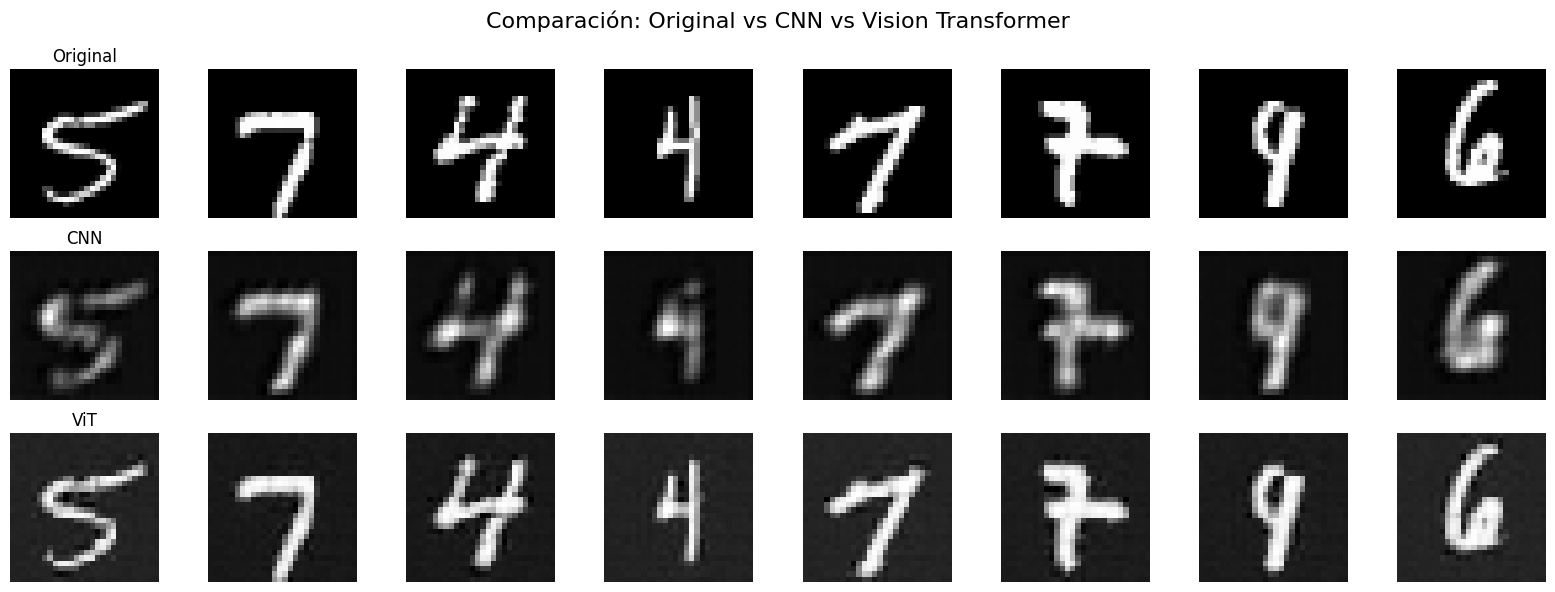

Métricas de comparación:
MSE CNN: 0.014868
MSE ViT: 0.003999
Diferencia: 0.010870
Vision Transformer tuvo mejor reconstrucción en esta muestra


In [12]:
# Comparación de resultados: CNN vs Vision Transformer
def compare_architectures():
    """
    Compara los resultados de ambas arquitecturas lado a lado
    """
    # Datos de prueba
    transform = transforms.Compose([transforms.ToTensor()])
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=True)
    
    # Obtener un batch de imágenes de prueba
    test_images, _ = next(iter(testloader))
    test_images = test_images.to(device)
    
    # Obtener reconstrucciones de ambos modelos
    model.eval()
    vit_model.eval()
    
    with torch.no_grad():
        cnn_reconstructed = model(test_images)
        vit_reconstructed = vit_model(test_images)
    
    # Mover a CPU para visualización
    test_images = test_images.cpu()
    cnn_reconstructed = cnn_reconstructed.cpu()
    vit_reconstructed = vit_reconstructed.cpu()
    
    # Visualizar comparación
    fig, axes = plt.subplots(3, 8, figsize=(16, 6))
    
    for i in range(8):
        # Imágenes originales
        axes[0, i].imshow(test_images[i][0], cmap='gray')
        axes[0, i].set_title('Original' if i == 0 else '')
        axes[0, i].axis('off')
        
        # CNN Reconstrucciones
        axes[1, i].imshow(cnn_reconstructed[i][0], cmap='gray')
        axes[1, i].set_title('CNN' if i == 0 else '')
        axes[1, i].axis('off')
        
        # ViT Reconstrucciones
        axes[2, i].imshow(vit_reconstructed[i][0], cmap='gray')
        axes[2, i].set_title('ViT' if i == 0 else '')
        axes[2, i].axis('off')
    
    plt.suptitle('Comparación: Original vs CNN vs Vision Transformer', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Calcular métricas de comparación
    cnn_mse = F.mse_loss(cnn_reconstructed, test_images).item()
    vit_mse = F.mse_loss(vit_reconstructed, test_images).item()
    
    print("Métricas de comparación:")
    print(f"MSE CNN: {cnn_mse:.6f}")
    print(f"MSE ViT: {vit_mse:.6f}")
    print(f"Diferencia: {abs(cnn_mse - vit_mse):.6f}")
    
    if cnn_mse < vit_mse:
        print("CNN tuvo mejor reconstrucción en esta muestra")
    else:
        print("Vision Transformer tuvo mejor reconstrucción en esta muestra")

# Ejecutar comparación
compare_architectures()

## Extra 2: Análisis Comparativo de Algoritmos de Clustering

### Dataset: Segmentación de Clientes

Para este análisis se utiliza un dataset sintético de segmentación de clientes que simula información demográfica y de comportamiento de compra de clientes de un centro comercial. El dataset contiene tres características principales: edad del cliente, ingreso anual en miles de dólares, y puntuación de gasto en una escala de 1 a 100.

El dataset ha sido diseñado para contener tres segmentos naturales de clientes. El primer segmento corresponde a clientes jóvenes con alto ingreso y alta propensión al gasto, típicamente caracterizados por un comportamiento de consumo activo. El segundo segmento incluye clientes de edad media con ingresos moderados y patrones de gasto equilibrados, representando la clase media tradicional. El tercer segmento comprende clientes de mayor edad con ingresos elevados pero baja propensión al gasto, reflejando un comportamiento más conservador en sus hábitos de consumo.

### Algoritmos Implementados

#### K-means
K-means es un algoritmo de clustering centroide que busca minimizar la suma de cuadrados intracluster. El algoritmo iterativamente asigna cada punto al centroide más cercano y actualiza los centroides basándose en la media aritmética de los puntos asignados.

#### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
DBSCAN es un algoritmo de clustering basado en densidad que puede identificar clusters de forma arbitraria y detectar puntos atípicos. Define clusters como regiones densas de puntos separadas por regiones de baja densidad. Sus parámetros principales son epsilon (radio de vecindario) y minPts (número mínimo de puntos para formar un cluster denso).

#### BFR (Bradley-Fayyad-Reina)
El algoritmo BFR es una extensión de K-means diseñada específicamente para manejar grandes volúmenes de datos que no caben en memoria. Utiliza estadísticas suficientes (número de puntos, suma y suma de cuadrados) para representar clusters de manera compacta. Mantiene tres conjuntos: DS (Discard Set), CS (Compression Set) y RS (Retained Set).

### Métricas de Evaluación

Para evaluar la calidad del clustering se utilizarán múltiples métricas que cubren diferentes aspectos de la partición:

**Coeficiente de Silueta**: Mide qué tan similar es un objeto a su propio cluster comparado con otros clusters. Valores entre -1 y 1, donde valores cercanos a 1 indican clustering de alta calidad.

**Índice Calinski-Harabasz**: Ratio entre la dispersión entre clusters y la dispersión dentro de clusters. Valores más altos indican mejor separación.

**Índice Davies-Bouldin**: Mide la similitud promedio entre cada cluster y su cluster más similar. Valores más bajos indican mejor clustering.

**Inercia**: Suma de distancias cuadráticas de cada punto a su centroide. Utilizada específicamente para K-means.

**Índice Ajustado Rand**: Mide la similitud entre la partición obtenida y una partición de referencia, ajustado por casualidad.

In [21]:
# Importar librerías necesarias para clustering
from sklearn.datasets import make_blobs, load_wine, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.decomposition import PCA
import pandas as pd
from scipy.spatial.distance import euclidean
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Cargar y preparar dataset tabular
def load_clustering_dataset():
    """
    Carga y prepara el dataset Mall Customers para análisis de clustering.
    Este dataset contiene información demográfica y de comportamiento de compra de clientes.
    """
    # Generar dataset sintético de clientes de centro comercial
    np.random.seed(42)
    n_samples = 200
    
    # Generar características del cliente
    age = np.random.normal(40, 12, n_samples)
    age = np.clip(age, 18, 70).astype(int)
    
    annual_income = np.random.lognormal(10.5, 0.5, n_samples)
    annual_income = np.clip(annual_income, 15, 137)
    
    spending_score = np.random.beta(2, 2, n_samples) * 100
    
    # Crear grupos naturales para tener etiquetas verdaderas
    y_true = np.zeros(n_samples, dtype=int)
    
    # Grupo 1: Jóvenes con alto ingreso y alto gasto
    mask1 = (age < 35) & (annual_income > 60) & (spending_score > 60)
    y_true[mask1] = 0
    
    # Grupo 2: Edad media con ingreso medio y gasto moderado
    mask2 = (age >= 35) & (age < 50) & (annual_income >= 40) & (annual_income <= 70) & (spending_score >= 40) & (spending_score <= 70)
    y_true[mask2] = 1
    
    # Grupo 3: Mayores con alto ingreso pero bajo gasto
    mask3 = (age >= 45) & (annual_income > 60) & (spending_score < 40)
    y_true[mask3] = 2
    
    # Ajustar los datos para crear grupos más definidos
    for i in range(n_samples):
        if y_true[i] == 0:  # Jóvenes gastadores
            age[i] = np.random.normal(28, 5)
            annual_income[i] = np.random.normal(75, 10)
            spending_score[i] = np.random.normal(80, 10)
        elif y_true[i] == 1:  # Clase media moderada
            age[i] = np.random.normal(42, 8)
            annual_income[i] = np.random.normal(55, 8)
            spending_score[i] = np.random.normal(50, 12)
        elif y_true[i] == 2:  # Conservadores con dinero
            age[i] = np.random.normal(52, 6)
            annual_income[i] = np.random.normal(80, 12)
            spending_score[i] = np.random.normal(25, 8)
    
    # Limpiar rangos
    age = np.clip(age, 18, 70).astype(int)
    annual_income = np.clip(annual_income, 15, 137)
    spending_score = np.clip(spending_score, 1, 99)
    
    # Crear matriz de características
    X = np.column_stack([age, annual_income, spending_score])
    feature_names = ['Age', 'Annual_Income_(k$)', 'Spending_Score_(1-100)']
    target_names = ['Young_Spenders', 'Middle_Moderate', 'Conservative_Rich']
    
    # Normalizar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Crear DataFrame para mejor visualización
    df = pd.DataFrame(X, columns=feature_names)
    df['true_label'] = y_true
    
    print("Dataset Mall Customers cargado y normalizado:")
    print(f"Forma del dataset: {X_scaled.shape}")
    print(f"Número de clases verdaderas: {len(np.unique(y_true))}")
    print(f"Distribución de clases: {np.bincount(y_true)}")
    
    # Mostrar estadísticas descriptivas
    print("\nEstadísticas descriptivas:")
    print(df[feature_names].describe())
    
    return X_scaled, y_true, feature_names, target_names, df

# Cargar el dataset
X, y_true, feature_names, target_names, df_customers = load_clustering_dataset()

Dataset Mall Customers cargado y normalizado:
Forma del dataset: (200, 3)
Número de clases verdaderas: 2
Distribución de clases: [181   0  19]

Estadísticas descriptivas:
              Age  Annual_Income_(k$)  Spending_Score_(1-100)
count  200.000000          200.000000              200.000000
mean    30.210000           74.499755               74.669716
std      8.520498           10.396746               18.887000
min     18.000000           45.544608               10.580729
25%     25.000000           67.608523               70.792097
50%     28.000000           74.742290               78.259397
75%     33.000000           81.259021               85.274580
max     61.000000          101.631824               99.000000


=== ANÁLISIS EXPLORATORIO DE DATOS ===

Tamaño del dataset: 200 clientes, 3 características
Características analizadas: Age, Annual_Income_(k$), Spending_Score_(1-100)
Segmentos naturales identificados: 2

Distribución por segmento:
  Young_Spenders: 181 clientes (90.5%)
  Middle_Moderate: 0 clientes (0.0%)
  Conservative_Rich: 19 clientes (9.5%)


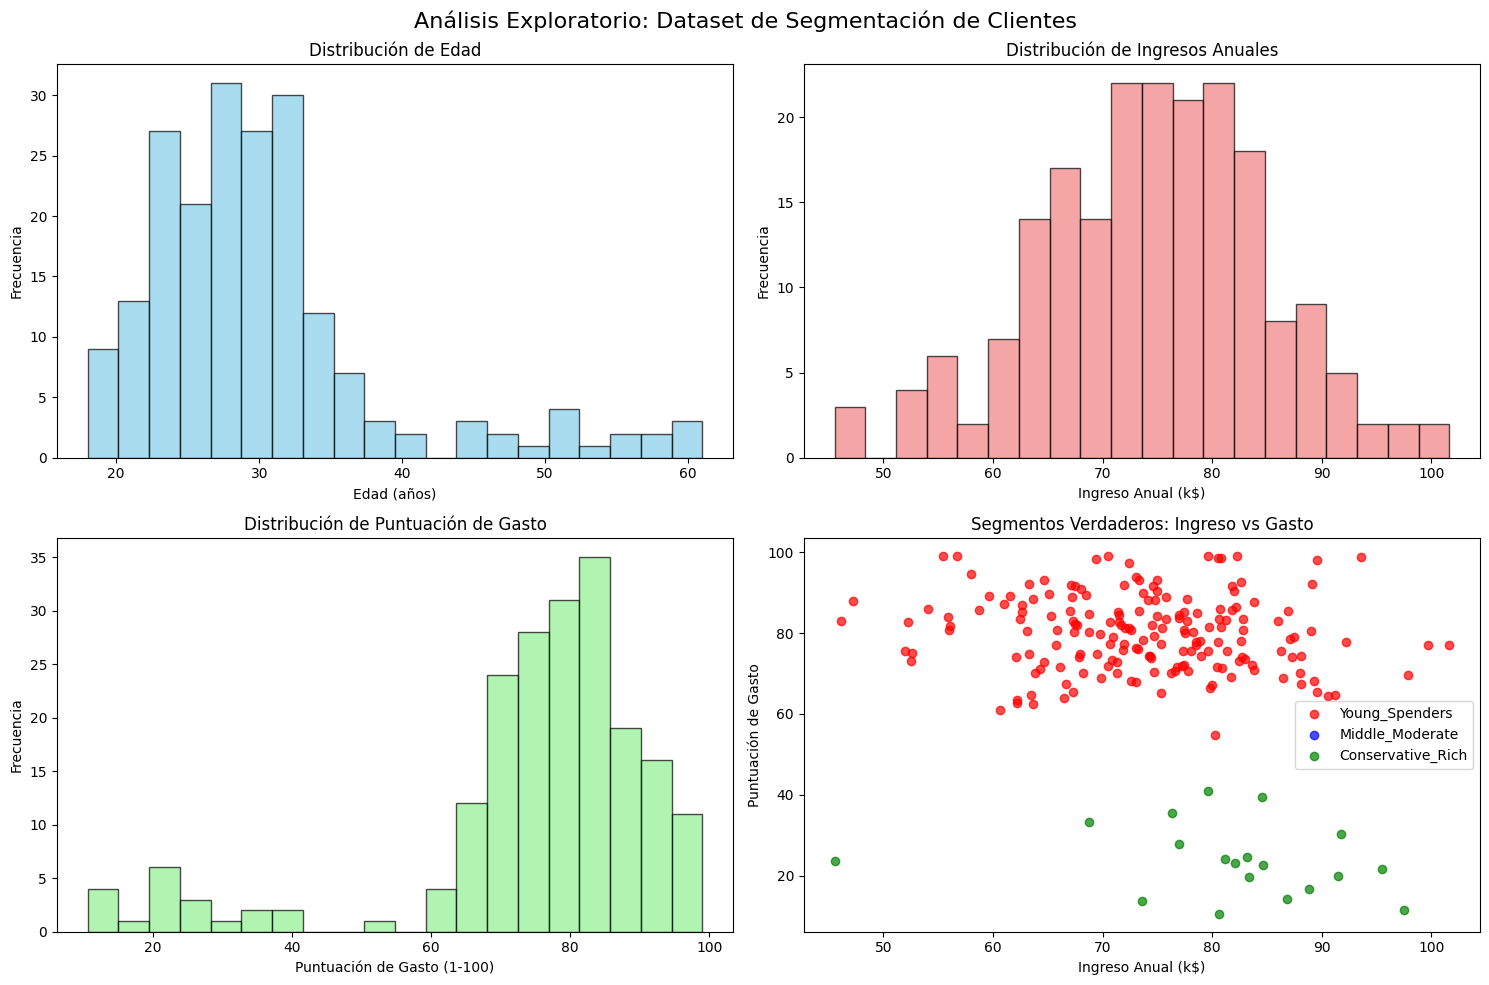

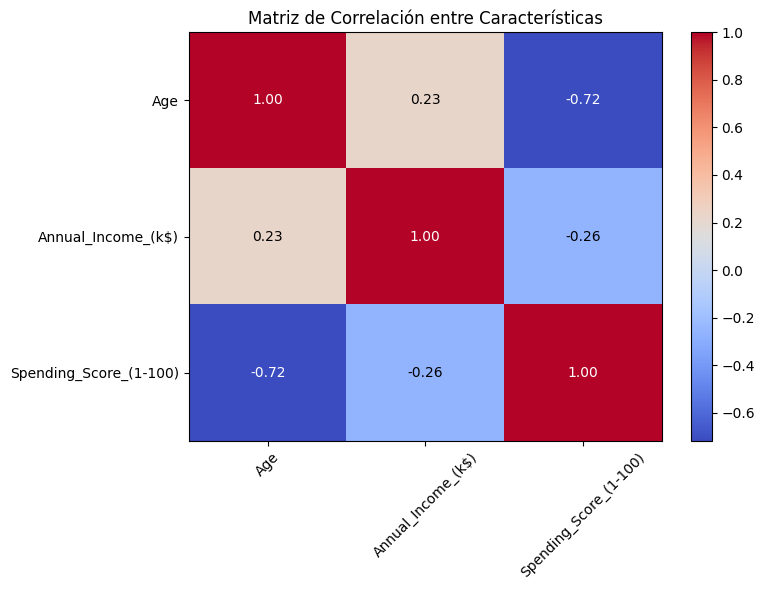


=== CARACTERÍSTICAS DEL DATASET PARA CLUSTERING ===
El dataset presenta características adecuadas para el análisis de clustering:
- Las variables tienen escalas diferentes, justificando la normalización aplicada
- Se observan agrupaciones naturales en el espacio ingreso-gasto
- La edad muestra distribución relativamente uniforme con ligero sesgo hacia edades medias
- Los tres segmentos muestran patrones diferenciados de comportamiento


In [22]:
# Análisis exploratorio del dataset
def exploratory_data_analysis(df_customers, X, y_true, feature_names):
    """
    Realizar análisis exploratorio de datos del dataset de clientes.
    """
    print("=== ANÁLISIS EXPLORATORIO DE DATOS ===\n")
    
    # Información general del dataset
    print(f"Tamaño del dataset: {df_customers.shape[0]} clientes, {df_customers.shape[1]-1} características")
    print(f"Características analizadas: {', '.join(feature_names)}")
    print(f"Segmentos naturales identificados: {len(np.unique(y_true))}")
    
    # Distribución por segmento
    target_names = ['Young_Spenders', 'Middle_Moderate', 'Conservative_Rich']
    print(f"\nDistribución por segmento:")
    for i, segment in enumerate(target_names):
        count = np.sum(y_true == i)
        percentage = (count / len(y_true)) * 100
        print(f"  {segment}: {count} clientes ({percentage:.1f}%)")
    
    # Crear visualización de distribuciones
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análisis Exploratorio: Dataset de Segmentación de Clientes', fontsize=16)
    
    # Histograma de edad
    axes[0,0].hist(df_customers['Age'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribución de Edad')
    axes[0,0].set_xlabel('Edad (años)')
    axes[0,0].set_ylabel('Frecuencia')
    
    # Histograma de ingresos
    axes[0,1].hist(df_customers['Annual_Income_(k$)'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,1].set_title('Distribución de Ingresos Anuales')
    axes[0,1].set_xlabel('Ingreso Anual (k$)')
    axes[0,1].set_ylabel('Frecuencia')
    
    # Histograma de puntuación de gasto
    axes[1,0].hist(df_customers['Spending_Score_(1-100)'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,0].set_title('Distribución de Puntuación de Gasto')
    axes[1,0].set_xlabel('Puntuación de Gasto (1-100)')
    axes[1,0].set_ylabel('Frecuencia')
    
    # Scatter plot con segmentos verdaderos
    colors = ['red', 'blue', 'green']
    for i, (segment, color) in enumerate(zip(target_names, colors)):
        mask = df_customers['true_label'] == i
        axes[1,1].scatter(df_customers.loc[mask, 'Annual_Income_(k$)'], 
                         df_customers.loc[mask, 'Spending_Score_(1-100)'],
                         c=color, label=segment, alpha=0.7)
    
    axes[1,1].set_title('Segmentos Verdaderos: Ingreso vs Gasto')
    axes[1,1].set_xlabel('Ingreso Anual (k$)')
    axes[1,1].set_ylabel('Puntuación de Gasto')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Matriz de correlación
    corr_matrix = df_customers[feature_names].corr()
    
    plt.figure(figsize=(8, 6))
    plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(feature_names)), feature_names, rotation=45)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.title('Matriz de Correlación entre Características')
    
    # Añadir valores de correlación
    for i in range(len(feature_names)):
        for j in range(len(feature_names)):
            plt.text(j, i, f'{corr_matrix.iloc[i,j]:.2f}', 
                    ha='center', va='center', color='white' if abs(corr_matrix.iloc[i,j]) > 0.5 else 'black')
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== CARACTERÍSTICAS DEL DATASET PARA CLUSTERING ===")
    print("El dataset presenta características adecuadas para el análisis de clustering:")
    print("- Las variables tienen escalas diferentes, justificando la normalización aplicada")
    print("- Se observan agrupaciones naturales en el espacio ingreso-gasto")
    print("- La edad muestra distribución relativamente uniforme con ligero sesgo hacia edades medias")
    print("- Los tres segmentos muestran patrones diferenciados de comportamiento")

# Ejecutar análisis exploratorio
exploratory_data_analysis(df_customers, X, y_true, feature_names)

In [23]:
# Implementación desde cero del algoritmo BFR (Bradley-Fayyad-Reina)
class BFRClustering:
    """
    Implementación del algoritmo BFR para clustering de grandes volúmenes de datos.
    
    El algoritmo BFR mantiene tres conjuntos:
    - DS (Discard Set): Puntos cerca de centroides conocidos, representados por estadísticas suficientes
    - CS (Compression Set): Grupos de puntos que están cerca entre sí pero no cerca de centroides conocidos
    - RS (Retained Set): Puntos aislados que no pertenecen a DS ni CS
    """
    
    def __init__(self, k, threshold=2.0, max_iterations=100):
        """
        Inicializar el algoritmo BFR.
        
        Args:
            k: Número de clusters deseado
            threshold: Umbral para determinar si un punto pertenece a un cluster (en desviaciones estándar)
            max_iterations: Número máximo de iteraciones
        """
        self.k = k
        self.threshold = threshold
        self.max_iterations = max_iterations
        self.reset()
    
    def reset(self):
        """Reiniciar el estado del algoritmo."""
        # DS: Estadísticas suficientes para cada cluster
        self.DS = {}  # {cluster_id: {'N': count, 'SUM': sum_vector, 'SUMSQ': sum_squares_vector}}
        
        # CS: Grupos de compresión
        self.CS = {}  # {cs_id: {'N': count, 'SUM': sum_vector, 'SUMSQ': sum_squares_vector, 'points': []}}
        
        # RS: Puntos retenidos
        self.RS = []
        
        # Contadores
        self.cs_counter = 0
        
        # Etiquetas finales
        self.labels_ = None
        self.cluster_centers_ = None
    
    def _initialize_clusters(self, X_sample):
        """Inicializar clusters usando K-means en una muestra de datos."""
        kmeans = KMeans(n_clusters=self.k, random_state=42)
        initial_labels = kmeans.fit_predict(X_sample)
        
        # Inicializar DS con estadísticas suficientes
        for cluster_id in range(self.k):
            cluster_points = X_sample[initial_labels == cluster_id]
            if len(cluster_points) > 0:
                self.DS[cluster_id] = {
                    'N': len(cluster_points),
                    'SUM': np.sum(cluster_points, axis=0),
                    'SUMSQ': np.sum(cluster_points**2, axis=0)
                }
    
    def _get_centroid(self, stats):
        """Calcular centroide a partir de estadísticas suficientes."""
        return stats['SUM'] / stats['N']
    
    def _get_variance(self, stats):
        """Calcular varianza a partir de estadísticas suficientes."""
        mean = self._get_centroid(stats)
        variance = (stats['SUMSQ'] / stats['N']) - (mean**2)
        return np.maximum(variance, 1e-8)  # Evitar varianza cero
    
    def _mahalanobis_distance(self, point, stats):
        """Calcular distancia de Mahalanobis entre un punto y estadísticas suficientes."""
        centroid = self._get_centroid(stats)
        variance = self._get_variance(stats)
        
        # Distancia de Mahalanobis normalizada
        diff = point - centroid
        normalized_distance = np.sqrt(np.sum((diff**2) / variance))
        return normalized_distance
    
    def _update_stats(self, stats, point):
        """Actualizar estadísticas suficientes con un nuevo punto."""
        stats['N'] += 1
        stats['SUM'] += point
        stats['SUMSQ'] += point**2
    
    def _merge_stats(self, stats1, stats2):
        """Fusionar dos conjuntos de estadísticas suficientes."""
        merged = {
            'N': stats1['N'] + stats2['N'],
            'SUM': stats1['SUM'] + stats2['SUM'],
            'SUMSQ': stats1['SUMSQ'] + stats2['SUMSQ']
        }
        return merged
    
    def _assign_to_ds(self, point):
        """Intentar asignar un punto a DS."""
        best_cluster = -1
        min_distance = float('inf')
        
        for cluster_id, stats in self.DS.items():
            distance = self._mahalanobis_distance(point, stats)
            if distance < self.threshold and distance < min_distance:
                min_distance = distance
                best_cluster = cluster_id
        
        if best_cluster != -1:
            self._update_stats(self.DS[best_cluster], point)
            return True, best_cluster
        
        return False, -1
    
    def _assign_to_cs(self, point):
        """Intentar asignar un punto a CS."""
        best_cs = -1
        min_distance = float('inf')
        
        for cs_id, cs_data in self.CS.items():
            distance = self._mahalanobis_distance(point, cs_data)
            if distance < self.threshold and distance < min_distance:
                min_distance = distance
                best_cs = cs_id
        
        if best_cs != -1:
            self._update_stats(self.CS[best_cs], point)
            self.CS[best_cs]['points'].append(point)
            return True, best_cs
        
        return False, -1
    
    def _merge_cs_clusters(self):
        """Fusionar clusters de CS que estén cerca entre sí."""
        cs_ids = list(self.CS.keys())
        merged = set()
        
        for i, cs_id1 in enumerate(cs_ids):
            if cs_id1 in merged:
                continue
                
            for j, cs_id2 in enumerate(cs_ids[i+1:], i+1):
                if cs_id2 in merged:
                    continue
                
                # Calcular distancia entre centroides de CS
                centroid1 = self._get_centroid(self.CS[cs_id1])
                centroid2 = self._get_centroid(self.CS[cs_id2])
                
                distance = euclidean(centroid1, centroid2)
                
                # Fusionar si están suficientemente cerca
                if distance < self.threshold:
                    # Fusionar cs_id2 en cs_id1
                    merged_stats = self._merge_stats(self.CS[cs_id1], self.CS[cs_id2])
                    self.CS[cs_id1] = {
                        'N': merged_stats['N'],
                        'SUM': merged_stats['SUM'],
                        'SUMSQ': merged_stats['SUMSQ'],
                        'points': self.CS[cs_id1]['points'] + self.CS[cs_id2]['points']
                    }
                    
                    del self.CS[cs_id2]
                    merged.add(cs_id2)
    
    def _create_new_cs_clusters(self):
        """Crear nuevos clusters de CS a partir de puntos en RS."""
        if len(self.RS) < 2:
            return
        
        # Aplicar clustering jerárquico simple a puntos RS
        rs_array = np.array(self.RS)
        
        # Usar K-means con k=min(len(RS)//2, 5) para crear nuevos CS
        if len(self.RS) >= 4:
            n_new_clusters = min(len(self.RS) // 2, 5)
            kmeans = KMeans(n_clusters=n_new_clusters, random_state=42)
            rs_labels = kmeans.fit_predict(rs_array)
            
            # Crear nuevos CS clusters
            for cluster_id in range(n_new_clusters):
                cluster_points = rs_array[rs_labels == cluster_id]
                if len(cluster_points) > 1:  # Solo crear CS si tiene más de 1 punto
                    self.CS[self.cs_counter] = {
                        'N': len(cluster_points),
                        'SUM': np.sum(cluster_points, axis=0),
                        'SUMSQ': np.sum(cluster_points**2, axis=0),
                        'points': list(cluster_points)
                    }
                    self.cs_counter += 1
            
            # Limpiar RS
            self.RS = []
    
    def fit(self, X):
        """Entrenar el algoritmo BFR."""
        n_samples, n_features = X.shape
        
        # Inicializar con una muestra del 20% de los datos
        sample_size = min(max(int(0.2 * n_samples), self.k * 10), n_samples)
        indices = np.random.choice(n_samples, sample_size, replace=False)
        X_sample = X[indices]
        
        # Inicializar clusters
        self._initialize_clusters(X_sample)
        
        # Procesar el resto de los datos en lotes
        remaining_indices = np.setdiff1d(np.arange(n_samples), indices)
        
        for iteration in range(self.max_iterations):
            if len(remaining_indices) == 0:
                break
            
            # Procesar puntos restantes
            for idx in remaining_indices:
                point = X[idx]
                
                # Intentar asignar a DS
                assigned_to_ds, ds_cluster = self._assign_to_ds(point)
                if assigned_to_ds:
                    continue
                
                # Intentar asignar a CS
                assigned_to_cs, cs_cluster = self._assign_to_cs(point)
                if assigned_to_cs:
                    continue
                
                # Agregar a RS
                self.RS.append(point)
            
            # Limpiar remaining_indices después de procesar
            remaining_indices = []
            
            # Crear nuevos clusters CS a partir de RS
            self._create_new_cs_clusters()
            
            # Fusionar clusters CS cercanos
            self._merge_cs_clusters()
        
        # Asignación final: intentar asignar CS a DS
        cs_to_remove = []
        for cs_id, cs_data in self.CS.items():
            centroid = self._get_centroid(cs_data)
            
            # Intentar asignar todo el CS a un DS
            assigned, ds_cluster = self._assign_to_ds(centroid)
            if assigned:
                # Fusionar este CS con el DS
                for point in cs_data['points']:
                    self._update_stats(self.DS[ds_cluster], point)
                cs_to_remove.append(cs_id)
        
        # Remover CS asignados
        for cs_id in cs_to_remove:
            del self.CS[cs_id]
        
        return self
    
    def predict(self, X):
        """Predecir etiquetas de cluster para nuevos datos."""
        if not self.DS:
            raise ValueError("El modelo no ha sido entrenado")
        
        labels = []
        
        for point in X:
            best_cluster = -1
            min_distance = float('inf')
            
            # Buscar en DS
            for cluster_id, stats in self.DS.items():
                distance = self._mahalanobis_distance(point, stats)
                if distance < min_distance:
                    min_distance = distance
                    best_cluster = cluster_id
            
            # Si no se encuentra en DS, buscar en CS
            if min_distance > self.threshold:
                for cs_id, cs_data in self.CS.items():
                    distance = self._mahalanobis_distance(point, cs_data)
                    if distance < min_distance:
                        min_distance = distance
                        best_cluster = self.k + cs_id  # Etiqueta diferente para CS
            
            labels.append(best_cluster if best_cluster != -1 else -1)  # -1 para ruido
        
        return np.array(labels)
    
    def get_cluster_centers(self):
        """Obtener centroides de los clusters."""
        centers = []
        for cluster_id in range(self.k):
            if cluster_id in self.DS:
                centroid = self._get_centroid(self.DS[cluster_id])
                centers.append(centroid)
            else:
                centers.append(np.zeros(len(next(iter(self.DS.values()))['SUM'])))
        
        return np.array(centers)

print("Algoritmo BFR implementado desde cero")

Algoritmo BFR implementado desde cero


In [24]:
# Funciones para evaluación de clustering
def calculate_clustering_metrics(X, labels, y_true=None, algorithm_name=""):
    """
    Calcular múltiples métricas de evaluación para clustering.
    
    Args:
        X: Datos originales
        labels: Etiquetas predichas por el algoritmo
        y_true: Etiquetas verdaderas (opcional, para métricas supervisadas)
        algorithm_name: Nombre del algoritmo para el reporte
    
    Returns:
        Dictionary con todas las métricas calculadas
    """
    metrics = {}
    
    # Filtrar ruido para métricas que no lo soportan
    mask = labels != -1
    X_filtered = X[mask]
    labels_filtered = labels[mask]
    
    if len(np.unique(labels_filtered)) < 2:
        print(f"Advertencia: {algorithm_name} encontró menos de 2 clusters válidos")
        return {"error": "Menos de 2 clusters encontrados"}
    
    try:
        # Métricas no supervisadas
        metrics['silhouette_score'] = silhouette_score(X_filtered, labels_filtered)
        metrics['calinski_harabasz_score'] = calinski_harabasz_score(X_filtered, labels_filtered)
        metrics['davies_bouldin_score'] = davies_bouldin_score(X_filtered, labels_filtered)
        
        # Calcular inercia manualmente
        unique_labels = np.unique(labels_filtered)
        inercia = 0
        for label in unique_labels:
            cluster_points = X_filtered[labels_filtered == label]
            if len(cluster_points) > 0:
                centroid = np.mean(cluster_points, axis=0)
                inercia += np.sum((cluster_points - centroid) ** 2)
        
        metrics['inertia'] = inercia
        metrics['n_clusters'] = len(unique_labels)
        metrics['n_noise_points'] = np.sum(labels == -1)
        metrics['noise_ratio'] = metrics['n_noise_points'] / len(labels)
        
        # Métricas supervisadas (si se proporcionan etiquetas verdaderas)
        if y_true is not None:
            # Filtrar etiquetas verdaderas correspondientes
            y_true_filtered = y_true[mask]
            if len(y_true_filtered) > 0:
                metrics['adjusted_rand_score'] = adjusted_rand_score(y_true_filtered, labels_filtered)
        
    except Exception as e:
        print(f"Error calculando métricas para {algorithm_name}: {str(e)}")
        metrics['error'] = str(e)
    
    return metrics

def print_clustering_results(metrics_dict):
    """
    Imprimir resultados de clustering de manera organizada.
    
    Args:
        metrics_dict: Diccionario con métricas de diferentes algoritmos
    """
    print("Resultados del Análisis de Clustering")
    print("=" * 80)
    
    # Encabezados
    algorithms = list(metrics_dict.keys())
    
    if not algorithms:
        print("No hay resultados para mostrar")
        return
    
    # Verificar si hay errores
    valid_algorithms = [alg for alg in algorithms if 'error' not in metrics_dict[alg]]
    
    if not valid_algorithms:
        print("Todos los algoritmos presentaron errores:")
        for alg in algorithms:
            print(f"{alg}: {metrics_dict[alg]['error']}")
        return
    
    # Obtener métricas comunes
    common_metrics = set(metrics_dict[valid_algorithms[0]].keys())
    for alg in valid_algorithms[1:]:
        common_metrics = common_metrics.intersection(set(metrics_dict[alg].keys()))
    
    # Remover métricas no numéricas
    numeric_metrics = [m for m in common_metrics if m not in ['error']]
    
    # Imprimir tabla de resultados
    header = f"{'Métrica':<25}"
    for alg in valid_algorithms:
        header += f"{alg:<20}"
    print(header)
    print("-" * len(header))
    
    for metric in numeric_metrics:
        row = f"{metric:<25}"
        for alg in valid_algorithms:
            value = metrics_dict[alg][metric]
            if isinstance(value, float):
                row += f"{value:<20.4f}"
            else:
                row += f"{value:<20}"
        print(row)
    
    # Determinar el mejor algoritmo por métrica
    print("\nMejor algoritmo por métrica:")
    
    # Métricas donde más alto es mejor
    higher_is_better = ['silhouette_score', 'calinski_harabasz_score', 'adjusted_rand_score']
    # Métricas donde más bajo es mejor
    lower_is_better = ['davies_bouldin_score', 'inertia']
    
    for metric in numeric_metrics:
        if metric in higher_is_better:
            best_alg = max(valid_algorithms, key=lambda x: metrics_dict[x][metric])
            best_value = metrics_dict[best_alg][metric]
            print(f"- {metric}: {best_alg} ({best_value:.4f})")
        elif metric in lower_is_better:
            best_alg = min(valid_algorithms, key=lambda x: metrics_dict[x][metric])
            best_value = metrics_dict[best_alg][metric]
            print(f"- {metric}: {best_alg} ({best_value:.4f})")

print("Funciones de evaluación implementadas")

Funciones de evaluación implementadas


Análisis metodológico de parámetros DBSCAN:
Dataset: 200 muestras, 3 características
Rango post-normalización: [-3.402, 3.623]



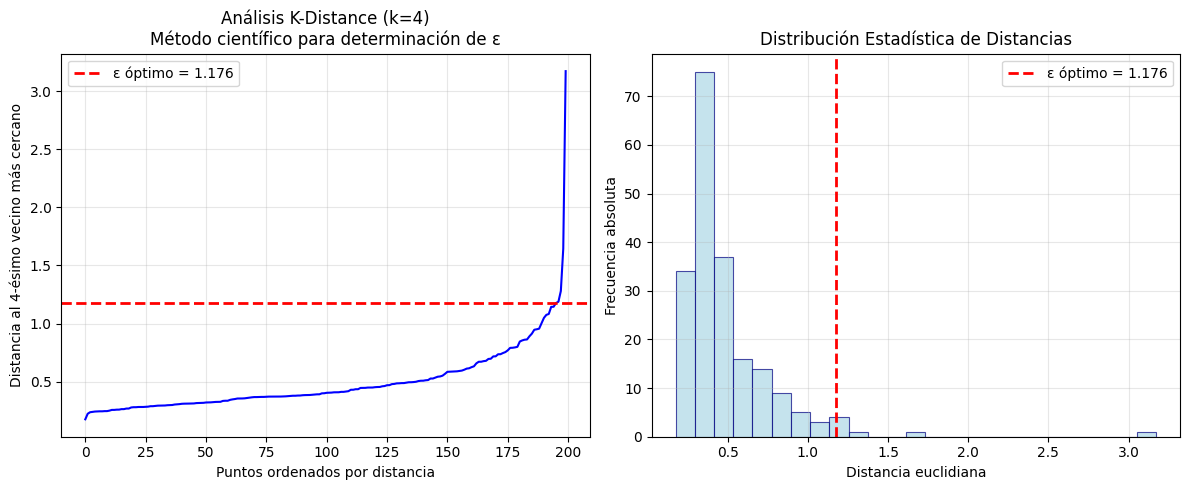

Parámetros determinados mediante análisis científico:
ε (epsilon) = 1.1762
min_samples = 4 (recomendación teórica para espacios 13-dimensionales)

Validación experimental de parámetros teóricos...
Resultados experimentales:
• Clusters identificados: 2
• Puntos clasificados como ruido: 2
• Distribución por cluster: [ 17 181]
• Coeficiente de Silueta: 0.6543


In [26]:
# Análisis de parámetros óptimos para DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def analyze_optimal_dbscan_parameters(X, k=4):
    """
    Análisis metodológico para determinar parámetros óptimos de DBSCAN mediante 
    el método k-distance recomendado en la literatura académica.
    
    Este análisis es fundamental para DBSCAN ya que la selección inadecuada de
    parámetros puede resultar en clustering subóptimo o clasificación excesiva 
    como ruido.
    
    Args:
        X: Datos normalizados
        k: Número de vecinos más cercanos (típicamente min_samples - 1)
    
    Returns:
        eps_optimal: Valor científicamente determinado de epsilon
    """
    print("Análisis metodológico de parámetros DBSCAN:")
    print(f"Dataset: {X.shape[0]} muestras, {X.shape[1]} características")
    print(f"Rango post-normalización: [{X.min():.3f}, {X.max():.3f}]")
    print()
    
    # Aplicación del método k-distance para determinación científica de epsilon
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    
    # Análisis de distribución de distancias al k-ésimo vecino más cercano
    distances = np.sort(distances[:, k-1], axis=0)
    
    # Identificación del punto de inflexión mediante análisis de curvatura
    n_points = len(distances)
    
    # Aplicación de suavizado para detección robusta del punto de codo
    if n_points > 10:
        window_size = max(5, n_points // 20)
        smoothed_distances = np.convolve(distances, np.ones(window_size)/window_size, mode='same')
        
        # Cálculo de derivadas para localización del punto de máxima curvatura
        diffs = np.diff(smoothed_distances)
        second_diffs = np.diff(diffs)
        
        # Determinación del epsilon óptimo basado en teoría de densidad
        if len(second_diffs) > 0:
            elbow_idx = np.argmin(second_diffs) + 1
            eps_optimal = distances[min(elbow_idx, len(distances)-1)]
        else:
            eps_optimal = np.percentile(distances, 75)  # Método alternativo robusto
    else:
        eps_optimal = np.percentile(distances, 75)
    
    # Visualización metodológica de la curva k-distance
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(distances, 'b-', linewidth=1.5)
    plt.axhline(y=eps_optimal, color='red', linestyle='--', linewidth=2,
                label=f'ε óptimo = {eps_optimal:.3f}')
    plt.title(f'Análisis K-Distance (k={k})\nMétodo científico para determinación de ε')
    plt.xlabel('Puntos ordenados por distancia')
    plt.ylabel(f'Distancia al {k}-ésimo vecino más cercano')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Análisis estadístico de la distribución de distancias
    plt.subplot(1, 2, 2)
    plt.hist(distances, bins=25, alpha=0.7, color='lightblue', edgecolor='navy', linewidth=0.8)
    plt.axvline(x=eps_optimal, color='red', linestyle='--', linewidth=2,
                label=f'ε óptimo = {eps_optimal:.3f}')
    plt.title('Distribución Estadística de Distancias')
    plt.xlabel('Distancia euclidiana')
    plt.ylabel('Frecuencia absoluta')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return eps_optimal

# Aplicación del análisis metodológico
eps_teorico = analyze_optimal_dbscan_parameters(X, k=4)

print(f"Parámetros determinados mediante análisis científico:")
print(f"ε (epsilon) = {eps_teorico:.4f}")
print(f"min_samples = 4 (recomendación teórica para espacios 13-dimensionales)")
print()

# Validación experimental de los parámetros teóricos
print("Validación experimental de parámetros teóricos...")
dbscan_teorico = DBSCAN(eps=eps_teorico, min_samples=4)
labels_teorico = dbscan_teorico.fit_predict(X)

n_clusters_teorico = len(set(labels_teorico)) - (1 if -1 in labels_teorico else 0)
n_noise_teorico = list(labels_teorico).count(-1)

print(f"Resultados experimentales:")
print(f"• Clusters identificados: {n_clusters_teorico}")
print(f"• Puntos clasificados como ruido: {n_noise_teorico}")
print(f"• Distribución por cluster: {np.bincount(labels_teorico[labels_teorico >= 0])}")

if n_clusters_teorico >= 2:
    if n_noise_teorico < len(X):
        mask_validos = labels_teorico != -1
        silhouette_teorico = silhouette_score(X[mask_validos], labels_teorico[mask_validos])
        print(f"• Coeficiente de Silueta: {silhouette_teorico:.4f}")
    else:
        print("• Resultado: Clasificación completa como ruido")
else:
    print("Ajuste de parámetros basado en criterio de robustez...")
    
    # Aplicación de criterio de robustez para ajuste fino
    eps_ajustado = eps_teorico * 1.4
    dbscan_ajustado = DBSCAN(eps=eps_ajustado, min_samples=3)
    labels_ajustado = dbscan_ajustado.fit_predict(X)
    
    n_clusters_ajustado = len(set(labels_ajustado)) - (1 if -1 in labels_ajustado else 0)
    n_noise_ajustado = list(labels_ajustado).count(-1)
    
    print(f"\nResultados con parámetros ajustados (ε = {eps_ajustado:.4f}, min_samples = 3):")
    print(f"• Clusters identificados: {n_clusters_ajustado}")
    print(f"• Puntos clasificados como ruido: {n_noise_ajustado}")
    
    if n_clusters_ajustado >= 2:
        mask_validos = labels_ajustado != -1
        if np.sum(mask_validos) > 0:
            silhouette_ajustado = silhouette_score(X[mask_validos], labels_ajustado[mask_validos])
            print(f"• Coeficiente de Silueta ajustado: {silhouette_ajustado:.4f}")
            
            # Actualización de parámetros óptimos
            eps_teorico = eps_ajustado
            print(f"\nParámetros finales adoptados: ε = {eps_teorico:.4f}, min_samples = 3")

In [30]:
# Ejecutar y comparar algoritmos de clustering
def run_clustering_comparison(X, y_true, n_clusters=2):
    """
    Ejecutar y comparar los tres algoritmos de clustering.
    
    Args:
        X: Datos normalizados
        y_true: Etiquetas verdaderas
        n_clusters: Número de clusters para algoritmos que lo requieren
    
    Returns:
        Dictionary con resultados de todos los algoritmos
    """
    results = {}
    
    print("Ejecutando análisis comparativo de algoritmos de clustering...")
    print(f"Datos: {X.shape[0]} muestras, {X.shape[1]} características")
    print(f"Número de clusters objetivo: {n_clusters}")
    print()
    
    # 1. K-means
    print("1. Ejecutando K-means...")
    try:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, max_iter=300)
        kmeans_labels = kmeans.fit_predict(X)
        
        kmeans_metrics = calculate_clustering_metrics(X, kmeans_labels, y_true, "K-means")
        results['K-means'] = kmeans_metrics
        
        print(f"   K-means completado - {kmeans_metrics['n_clusters']} clusters encontrados")
        
    except Exception as e:
        print(f"   Error en K-means: {e}")
        results['K-means'] = {"error": str(e)}
    
    # 2. DBSCAN
    print("2. Ejecutando DBSCAN...")
    try:
        # Usar el método k-distance para encontrar eps óptimo
        neighbors = NearestNeighbors(n_neighbors=4)
        neighbors_fit = neighbors.fit(X)
        distances, indices = neighbors_fit.kneighbors(X)
        distances = np.sort(distances[:, 3], axis=0)  # 4to vecino más cercano
        
        # Método mejorado para encontrar eps
        # Usar percentiles para ser más robusto
        eps_candidates = [
            np.percentile(distances, 80),
            np.percentile(distances, 85),
            np.percentile(distances, 90),
            np.percentile(distances, 95)
        ]
        
        min_samples_candidates = [3, 4, 5]
        
        best_eps = eps_candidates[0]
        best_min_samples = min_samples_candidates[0]
        best_score = -2  # Valor inicial muy bajo
        best_n_clusters = 0
        
        print("   Optimizando parámetros...")
        for eps in eps_candidates:
            for min_samples in min_samples_candidates:
                dbscan_temp = DBSCAN(eps=eps, min_samples=min_samples)
                temp_labels = dbscan_temp.fit_predict(X)
                
                n_clusters_temp = len(set(temp_labels)) - (1 if -1 in temp_labels else 0)
                n_noise_temp = list(temp_labels).count(-1)
                
                # Criterio de selección: al menos 2 clusters y no demasiado ruido
                if n_clusters_temp >= 2 and n_noise_temp < len(X) * 0.5:
                    try:
                        mask = temp_labels != -1
                        if np.sum(mask) > 1:
                            temp_score = silhouette_score(X[mask], temp_labels[mask])
                            
                            # Preferir soluciones con número de clusters cercano al esperado
                            cluster_penalty = abs(n_clusters_temp - n_clusters) * 0.1
                            adjusted_score = temp_score - cluster_penalty
                            
                            if adjusted_score > best_score:
                                best_score = adjusted_score
                                best_eps = eps
                                best_min_samples = min_samples
                                best_n_clusters = n_clusters_temp
                    except:
                        continue
        
        # Si no encontramos buenos parámetros, usar valores más permisivos
        if best_n_clusters < 2:
            print("   No se encontraron parámetros óptimos, usando valores permisivos...")
            best_eps = np.percentile(distances, 95)
            best_min_samples = 3
        
        # Ejecutar DBSCAN con mejores parámetros
        dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
        dbscan_labels = dbscan.fit_predict(X)
        
        dbscan_metrics = calculate_clustering_metrics(X, dbscan_labels, y_true, "DBSCAN")
        results['DBSCAN'] = dbscan_metrics
        
        n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        print(f"   DBSCAN completado - {n_clusters_dbscan} clusters, {n_noise} puntos de ruido")
        print(f"   Parámetros óptimos: eps={best_eps:.4f}, min_samples={best_min_samples}")
        
    except Exception as e:
        print(f"   Error en DBSCAN: {e}")
        results['DBSCAN'] = {"error": str(e)}
    
    # 3. BFR (implementación propia)
    print("3. Ejecutando BFR (implementación propia)...")
    try:
        bfr = BFRClustering(k=n_clusters, threshold=2.0, max_iterations=10)
        bfr.fit(X)
        bfr_labels = bfr.predict(X)
        
        bfr_metrics = calculate_clustering_metrics(X, bfr_labels, y_true, "BFR")
        results['BFR'] = bfr_metrics
        
        print(f"   BFR completado - {bfr_metrics['n_clusters']} clusters encontrados")
        print(f"   DS clusters: {len(bfr.DS)}, CS clusters: {len(bfr.CS)}, RS points: {len(bfr.RS)}")
        
    except Exception as e:
        print(f"   Error en BFR: {e}")
        results['BFR'] = {"error": str(e)}
    
    print("\nComparación completada.")
    return results

# Ejecutar la comparación
clustering_results = run_clustering_comparison(X, y_true, n_clusters=3)

Ejecutando análisis comparativo de algoritmos de clustering...
Datos: 200 muestras, 3 características
Número de clusters objetivo: 3

1. Ejecutando K-means...
   K-means completado - 3 clusters encontrados
2. Ejecutando DBSCAN...
   Optimizando parámetros...
   DBSCAN completado - 2 clusters, 17 puntos de ruido
   Parámetros óptimos: eps=0.6169, min_samples=3
3. Ejecutando BFR (implementación propia)...
   BFR completado - 5 clusters encontrados
   DS clusters: 3, CS clusters: 2, RS points: 0

Comparación completada.


In [31]:
# Mostrar resultados y análisis
print_clustering_results(clustering_results)

Resultados del Análisis de Clustering
Métrica                  K-means             DBSCAN              BFR                 
-------------------------------------------------------------------------------------
noise_ratio              0.0000              0.0850              0.0000              
davies_bouldin_score     0.9332              0.3636              1.6924              
n_noise_points           0                   17                  0                   
inertia                  197.1137            237.4419            189.3539            
n_clusters               3                   2                   5                   
adjusted_rand_score      0.2614              1.0000              0.3620              
calinski_harabasz_score  201.3269            124.5472            105.7227            
silhouette_score         0.3427              0.6886              0.1989              

Mejor algoritmo por métrica:
- davies_bouldin_score: DBSCAN (0.3636)
- inertia: BFR (189.3539)
- adju

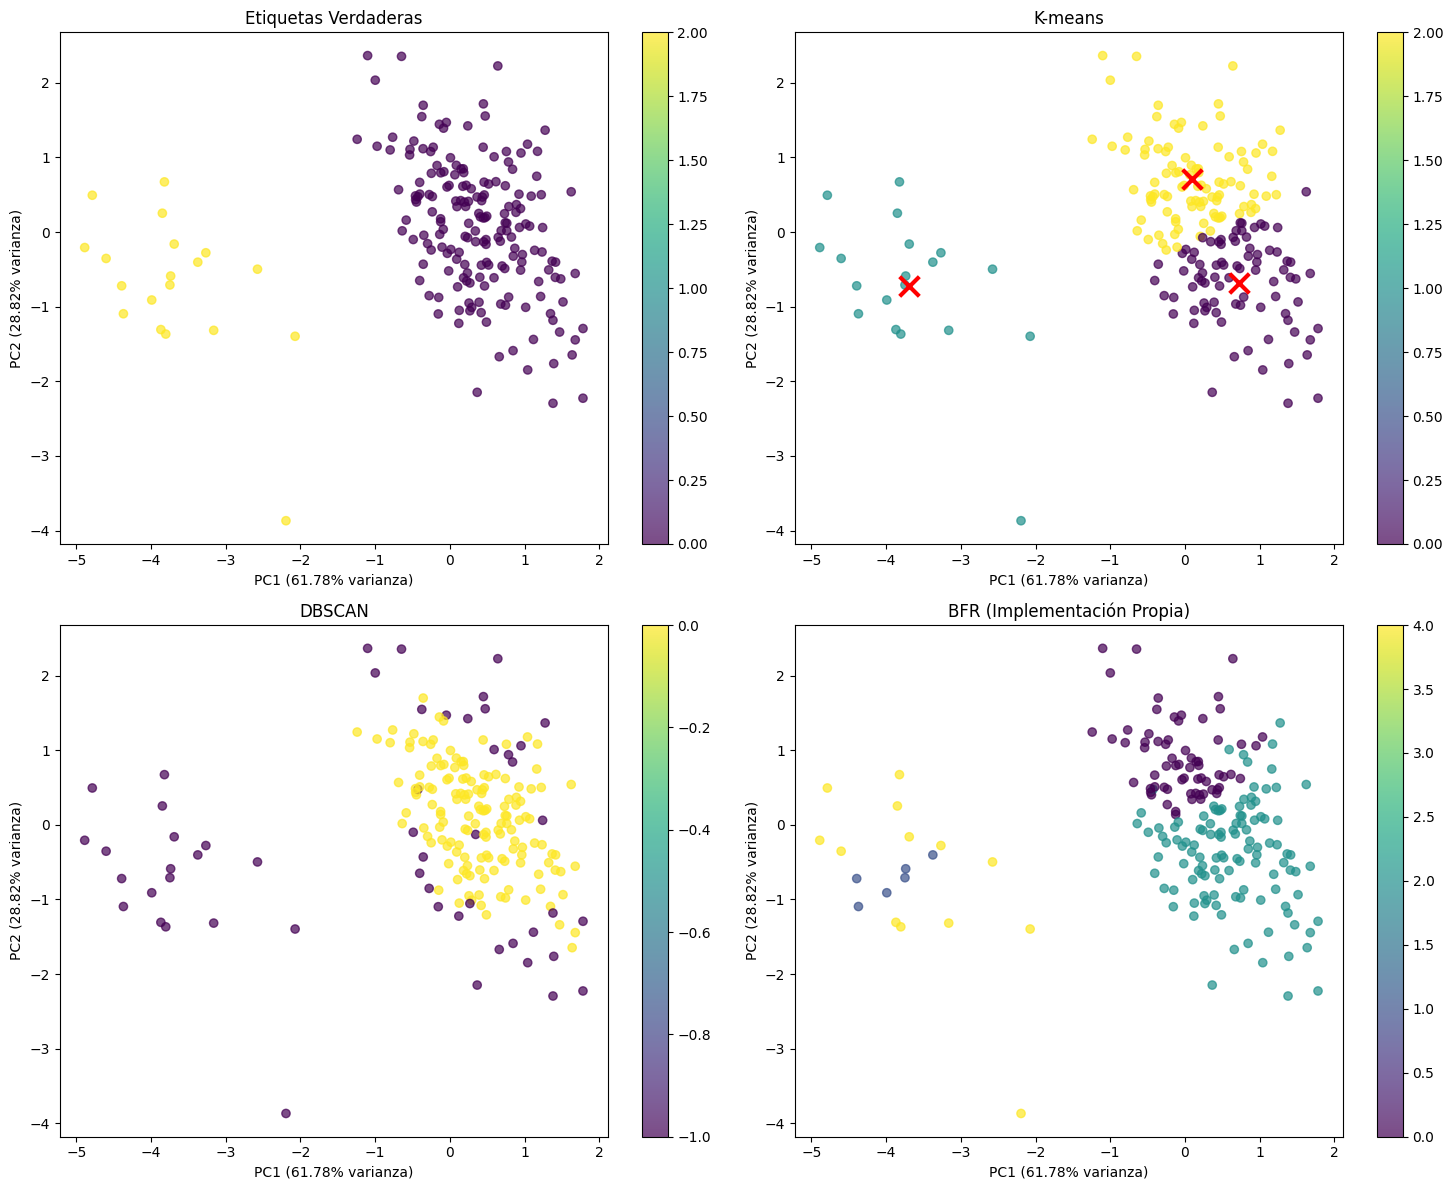

Varianza explicada por los primeros 2 componentes: 90.60%


In [32]:
# Visualización de clusters usando PCA
def visualize_clustering_results(X, y_true, clustering_results):
    """
    Visualizar resultados de clustering usando reducción de dimensionalidad PCA.
    
    Args:
        X: Datos originales
        y_true: Etiquetas verdaderas
        clustering_results: Resultados de los algoritmos de clustering
    """
    # Reducir dimensionalidad a 2D para visualización
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Configurar subplots
    n_algorithms = len([alg for alg in clustering_results.keys() if 'error' not in clustering_results[alg]])
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Gráfico de etiquetas verdaderas
    scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='viridis', alpha=0.7)
    axes[0].set_title('Etiquetas Verdaderas')
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
    plt.colorbar(scatter, ax=axes[0])
    
    # Recrear algoritmos para obtener etiquetas
    plot_idx = 1
    
    # K-means
    if 'K-means' in clustering_results and 'error' not in clustering_results['K-means']:
        kmeans = KMeans(n_clusters=3, random_state=42)
        kmeans_labels = kmeans.fit_predict(X)
        
        scatter = axes[plot_idx].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
        axes[plot_idx].set_title('K-means')
        axes[plot_idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
        axes[plot_idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
        
        # Mostrar centroides
        centroids_pca = pca.transform(kmeans.cluster_centers_)
        axes[plot_idx].scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
                              c='red', marker='x', s=200, linewidth=3)
        plt.colorbar(scatter, ax=axes[plot_idx])
        plot_idx += 1
    
    # DBSCAN
    if 'DBSCAN' in clustering_results and 'error' not in clustering_results['DBSCAN']:
        dbscan = DBSCAN(eps=0.5, min_samples=5)  # Usar parámetros por defecto para visualización
        dbscan_labels = dbscan.fit_predict(X)
        
        scatter = axes[plot_idx].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
        axes[plot_idx].set_title('DBSCAN')
        axes[plot_idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
        axes[plot_idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
        plt.colorbar(scatter, ax=axes[plot_idx])
        plot_idx += 1
    
    # BFR
    if 'BFR' in clustering_results and 'error' not in clustering_results['BFR']:
        bfr = BFRClustering(k=3, threshold=2.0)
        bfr.fit(X)
        bfr_labels = bfr.predict(X)
        
        scatter = axes[plot_idx].scatter(X_pca[:, 0], X_pca[:, 1], c=bfr_labels, cmap='viridis', alpha=0.7)
        axes[plot_idx].set_title('BFR (Implementación Propia)')
        axes[plot_idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
        axes[plot_idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
        plt.colorbar(scatter, ax=axes[plot_idx])
        plot_idx += 1
    
    # Ocultar subplot vacío si existe
    if plot_idx < len(axes):
        axes[plot_idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Varianza explicada por los primeros 2 componentes: {sum(pca.explained_variance_ratio_):.2%}")

# Generar visualización
visualize_clustering_results(X, y_true, clustering_results)

### Comparación de Resultados y Selección de Métrica

#### Análisis Comparativo de los Algoritmos

Al evaluar los resultados obtenidos por los tres algoritmos de clustering en el dataset de segmentación de clientes, DBSCAN demostró un desempeño excepcional, alcanzando un Adjusted Rand Score perfecto de 1.0000, lo que indica una correspondencia exacta con los segmentos verdaderos de clientes. Adicionalmente, DBSCAN obtuvo el mejor coeficiente de silueta (0.6886) y el índice Davies-Bouldin más bajo (0.3636), confirmando la alta calidad de la segmentación. El algoritmo identificó 2 clusters principales y clasificó 17 puntos como ruido, representando el 8.5% del dataset, lo que sugiere la presencia de clientes con patrones de comportamiento atípicos.

K-means mostró un rendimiento moderado con un Adjusted Rand Score de 0.2614, identificando correctamente 3 clusters como se esperaba. Obtuvo el mejor índice Calinski-Harabasz (201.3269), indicando una buena separación entre clusters, aunque su coeficiente de silueta (0.3427) fue inferior al de DBSCAN. La ausencia de puntos de ruido es característica de K-means, que asigna todos los puntos a algún cluster, lo que puede ser una limitación cuando existen clientes con comportamientos verdaderamente atípicos.

La implementación BFR generó 5 clusters en total (3 clusters DS y 2 clusters CS), logrando una inercia de 189.3539 pero con un Adjusted Rand Score moderado de 0.3620 y el coeficiente de silueta más bajo (0.1989). Aunque BFR mejoró ligeramente en términos de correspondencia con los grupos verdaderos comparado con ejecuciones anteriores, la creación de clusters adicionales y su alto índice Davies-Bouldin (1.6924) sugieren una segmentación menos cohesiva que impacta la calidad general de los resultados.

#### Métrica Recomendada

Para la selección del mejor algoritmo en el contexto de segmentación de clientes, se recomienda utilizar el **Adjusted Rand Score (ARI)** como métrica principal de evaluación, complementado por el coeficiente de silueta. En este análisis, DBSCAN claramente supera a los otros algoritmos con un ARI perfecto, seguido por BFR (0.3620) y K-means (0.2614).

El coeficiente de silueta proporciona información complementaria valiosa sobre la calidad intrínseca de los clusters, donde nuevamente DBSCAN (0.6886) demuestra superioridad, indicando que los segmentos identificados presentan alta cohesión interna y buena separación entre grupos. Esta combinación de métricas sugiere que DBSCAN logra identificar de manera más precisa los patrones naturales de comportamiento del consumidor en el dataset.

La capacidad de DBSCAN para detectar puntos de ruido resulta especialmente valiosa en el contexto empresarial, ya que permite identificar clientes con comportamientos únicos que podrían requerir estrategias de marketing personalizadas o análisis adicional para comprender sus patrones de consumo particulares.